In [1]:
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

In [2]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
sample = pd.read_csv('submit_sample.csv', header=None)

In [3]:
dt_now = datetime.datetime.now()
pred_list = {}

In [4]:
test['y'] = -999

In [5]:
all_df = pd.concat([train, test], axis=0)
all_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,49,self-employed,married,tertiary,no,98357,yes,no,cellular,6,jul,101,2,417,0,failure,-999
18046,34,blue-collar,married,secondary,no,29621,yes,no,cellular,12,may,345,1,815,0,unknown,-999
18047,34,admin.,single,secondary,no,94260,yes,no,unknown,16,may,121,2,370,0,unknown,-999


In [6]:
import category_encoders as ce
ce_ohe = ce.OneHotEncoder(handle_unknown='impute')
ce_ohe.fit(all_df)

OneHotEncoder(cols=['job', 'marital', 'education', 'default', 'housing', 'loan',
                    'contact', 'month', 'poutcome'],
              handle_unknown='impute')

In [7]:
all_df = ce_ohe.transform(all_df)

In [8]:
all_df

,age,job_1,job_2,job_3,job_4,job_5,job_6,job_7,job_8,job_9,...,month_11,duration,campaign,pdays,previous,poutcome_1,poutcome_2,poutcome_3,poutcome_4,y
id,,,,,,,,,,,,,,,,,,,,,
0,31,1,0,0,0,0,0,0,0,0,...,0,101,3,498,0,1,0,0,0,0
1,29,0,1,0,0,0,0,0,0,0,...,0,158,2,702,0,0,1,0,0,1
2,35,0,0,1,0,0,0,0,0,0,...,0,351,1,826,0,0,0,1,0,0
3,31,0,0,0,1,0,0,0,0,0,...,0,658,2,120,0,0,0,1,0,0
4,48,0,0,0,0,1,0,0,0,0,...,0,177,1,273,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,49,0,0,0,0,0,0,0,0,1,...,0,101,2,417,0,0,0,1,0,-999
18046,34,0,0,0,0,0,1,0,0,0,...,0,345,1,815,0,0,1,0,0,-999
18047,34,0,0,0,0,0,0,1,0,0,...,0,121,2,370,0,0,1,0,0,-999


In [9]:
X = all_df[all_df['y'] != -999].drop('y', axis=1)
y = all_df[all_df['y'] != -999]['y']
X.shape, y.shape

((27100, 50), (27100,))

In [10]:
parameters = {
    'learning_rate': [0.05],
    'max_depth': [8],
    'random_state': [0],
}

parameters2 = {
    'eta': [0.1],
    'max_depth': [5],
    'random_state': [0],
}

# parameters3 = {
#     'max_depth': list(range(2, 11)),
#     'random_state': [0],
# }

# parameters = {
#     'max_depth': list(range(2, 11)),
#     'min_samples_leaf': [5,10,20,50,100,500],
#     'objective' : ['binary', 'cross_entropy'],
#     'learning_rate': [0.005, 0.05, 0.5, 0.1],
#     'random_state': [0],
#     'n_estimators': [1000],
#     'n_estimators': [40, 100, 1000],
#     'num_leaves': [6,8,12,16],
#     'early_stopping_round': [10],
# }

## LightGBM

In [11]:
lgb = LGBMClassifier()

gcv = GridSearchCV(lgb, parameters, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv.fit(X, y)


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05], 'max_depth': [8],
                         'random_state': [0]},
             return_train_score=True, scoring='roc_auc')

In [12]:
gcv.best_params_

{'learning_rate': 0.05, 'max_depth': 8, 'random_state': 0}

In [13]:
gcv.cv_results_

{'mean_fit_time': array([0.54773383]),
 'std_fit_time': array([0.01486565]),
 'mean_score_time': array([0.07260661]),
 'std_score_time': array([0.00712011]),
 'param_learning_rate': masked_array(data=[0.05],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[8],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_random_state': masked_array(data=[0],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.05, 'max_depth': 8, 'random_state': 0}],
 'split0_test_score': array([0.8383716]),
 'split1_test_score': array([0.8598328]),
 'split2_test_score': array([0.85070829]),
 'split3_test_score': array([0.84153826]),
 'split4_test_score': array([0.85828637]),
 'mean_test_score': array([0.84974746]),
 'std_test_score': array([0.00862961]),
 'rank_test_score': array([1]),
 'split0_train_score': array([0.91484125]),
 'split1_train_score

In [14]:
train_score = gcv.cv_results_['mean_train_score']
test_score = gcv.cv_results_['mean_test_score']
print(train_score)
print(test_score)

[0.91159356]
[0.84974746]


([<matplotlib.axis.XTick at 0x1a04d211988>,
 <a list of 9 Text xticklabel objects>)

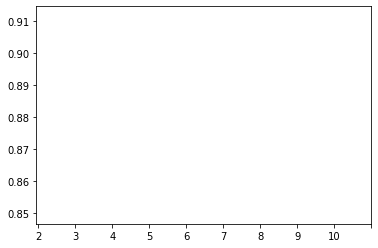

In [15]:
plt.plot(train_score)
plt.plot(test_score)
plt.xticks(list(range(0, 10)), list(range(2, 11)))

In [16]:
y_pred = gcv.predict_proba(X)[:,1]
y_pred

array([0.01714453, 0.18361177, 0.00656529, ..., 0.08018772, 0.05701548,
       0.0039001 ])

In [17]:
roc_auc_score(y, y_pred)
# 0.9113408811229391

0.9044405613937114

In [18]:
print(dt_now.strftime('%Y%m%d%H%M'))

202008132036


In [19]:
pred_list['lgb'] = y_pred

## XGBoost

In [20]:
xgb = XGBClassifier()

gcv2 = GridSearchCV(xgb, parameters2, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv2.fit(X, y)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [21]:
gcv2.best_params_

{'eta': 0.1, 'max_depth': 5, 'random_state': 0}

In [22]:
train_score = gcv2.cv_results_['mean_train_score']
test_score = gcv2.cv_results_['mean_test_score']
print(train_score)
print(test_score)

[0.91100294]
[0.84853055]


([<matplotlib.axis.XTick at 0x1a04e143688>,
 <a list of 9 Text xticklabel objects>)

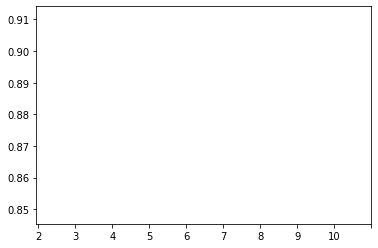

In [23]:
plt.plot(train_score)
plt.plot(test_score)
plt.xticks(list(range(0, 10)), list(range(2, 11)))

In [24]:
y_pred2 = gcv2.predict_proba(X)[:,1]
y_pred2

array([0.00878546, 0.18236674, 0.00662574, ..., 0.06958812, 0.05329811,
       0.00333176], dtype=float32)

In [25]:
roc_auc_score(y, y_pred2)
# 0.9113408811229391

0.9054471619862383

In [26]:
pred_list['xgb'] = y_pred2

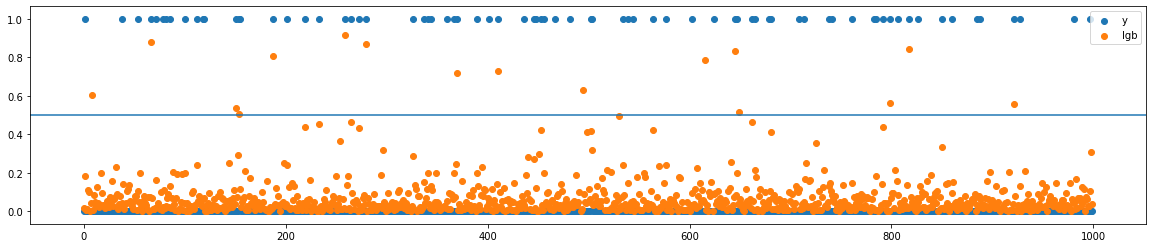

In [27]:
plt.figure(figsize=(20, 4))
plt.scatter(y.index[:1000], y[:1000], alpha=1, label='y')
plt.scatter(y.index[:1000], y_pred[:1000], alpha=1, label='lgb')
plt.axhline(0.5)
plt.legend()

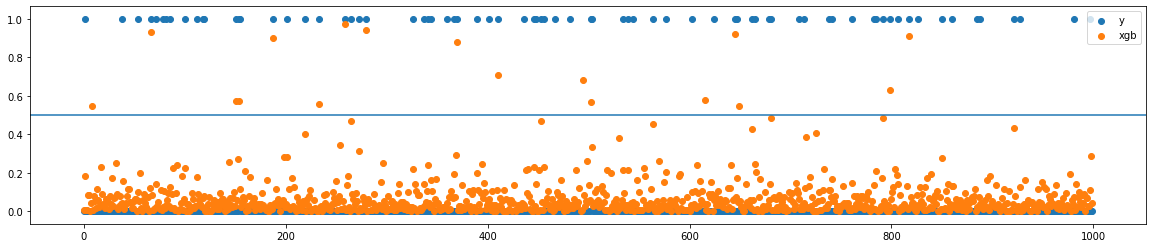

In [28]:
plt.figure(figsize=(20, 4))
plt.scatter(y.index[:1000], y[:1000], alpha=1, label='y')
plt.scatter(y.index[:1000], y_pred2[:1000], alpha=1, label='xgb')
plt.axhline(0.5)
plt.legend()

## Random Forest

In [29]:
parameters3 = {"max_depth": [2,3, None],
#               "n_estimators":[50,100,200,300,400,500],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [30]:
pred_list = pd.DataFrame(pred_list)

In [31]:
rf = RF()

gcv3 = GridSearchCV(rf, parameters3, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv3.fit(pred_list, y)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, None],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10]},
             return_train_score=True, scoring='roc_auc')

In [32]:
#rf.fit(pred_list, y)

In [34]:
y_pred3 = gcv3.predict_proba(pred_list)[:,1]
y_pred3

array([0.003427  , 0.2086259 , 0.00174288, ..., 0.06810426, 0.03524421,
       0.00174288])

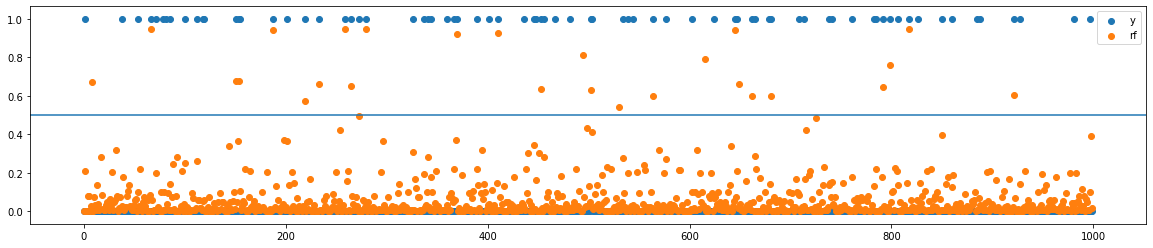

In [35]:
plt.figure(figsize=(20, 4))
plt.scatter(y.index[:1000], y[:1000], alpha=1, label='y')
plt.scatter(y.index[:1000], y_pred3[:1000], alpha=1, label='rf')
plt.axhline(0.5)
plt.legend()

In [36]:
roc_auc_score(y, y_pred3)
# 0.9113408811229391

0.9084007577425043

# Test Data Predict

In [37]:
X1 = all_df[all_df['y'] == -999].drop('y', axis=1)
all_predict= {}

## LightGBM

In [38]:
all_predict['pred_x1'] = gcv.predict_proba(X1)[:,1]
all_predict['pred_x1']

array([0.80737806, 0.06543166, 0.03720168, ..., 0.07000595, 0.00722807,
       0.08971905])

## XGBoost

In [39]:
all_predict['pred_x2'] = gcv2.predict_proba(X1)[:,1]
all_predict['pred_x2']

array([0.70784783, 0.0822614 , 0.03469273, ..., 0.07350367, 0.00601747,
       0.08651873], dtype=float32)

## Random Forest

In [40]:
pd.DataFrame(all_predict)

,pred_x1,pred_x2
0,0.807378,0.707848
1,0.065432,0.082261
2,0.037202,0.034693
3,0.003818,0.003326
4,0.087199,0.097921
...,...,...
18045,0.012102,0.008309
18046,0.009436,0.010662
18047,0.070006,0.073504
18048,0.007228,0.006017


In [42]:
pred_x3 = gcv3.predict_proba(pd.DataFrame(all_predict))
pred_x3[:,1]

array([0.9282555 , 0.05649864, 0.01926654, ..., 0.05642999, 0.00174288,
       0.07551116])

In [43]:
sample[1] = pred_x3[:,1]

In [44]:
sample.to_csv('submit_20200813_2.csv', header=None, index=None)